In [1]:
import geopandas
import pandas
import starepandas
import pystare
import shapely
import matplotlib.pyplot as plt

# Points

## Creating a naive dataframe

In [2]:
cities = ['Buenos Aires', 'Brasilia', 'Santiago', 'Bogota', 'Caracas']
countries = ['Argentina', 'Brazil', 'Chile', 'Colombia', 'Venezuela']
latitudes = [-34.58, -15.78, -33.45, 4.60, 10.48]
longitudes = [-58.66, -47.91, -70.66, -74.08, -66.86]
data =  {'City': cities,  'Country': countries, 
         'Latitude': latitudes, 'Longitude': longitudes}

df = pandas.DataFrame(data)

## Creating a geodataframe

In [3]:
geom = geopandas.points_from_xy(df.Longitude, df.Latitude)
gdf = geopandas.GeoDataFrame(df, geometry=geom)
gdf

,City,Country,Latitude,Longitude,geometry
0,Buenos Aires,Argentina,-34.58,-58.66,POINT (-58.66000 -34.58000)
1,Brasilia,Brazil,-15.78,-47.91,POINT (-47.91000 -15.78000)
2,Santiago,Chile,-33.45,-70.66,POINT (-70.66000 -33.45000)
3,Bogota,Colombia,4.60,-74.08,POINT (-74.08000 4.60000)
4,Caracas,Venezuela,10.48,-66.86,POINT (-66.86000 10.48000)


## Creating a STARE indices

In [4]:
# Thos are all identical
stare = starepandas.stare_from_xy(df.Longitude, df.Latitude, level=5)
stare = starepandas.stare_from_xy_df(gdf, n_cores=2, level=5)
stare = starepandas.stare_from_gdf(gdf, level=5)

sdf = starepandas.STAREDataFrame(gdf)
sdf.set_stare(stare, inplace=True)

In [5]:
trixels = sdf.trixels()
sdf.set_trixels(trixels=trixels, inplace=True)

## Some plotting

<AxesSubplot:>

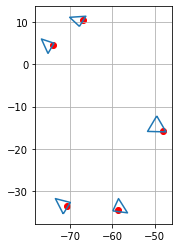

In [6]:
fig, ax = plt.subplots()
ax.grid(True)

#sdf.plot(ax=ax)
sdf.plot(ax=ax, trixels=True)
sdf.plot(ax=ax, trixels=False, color='r')

# From granule

## Bootstrap

In [10]:
import starepandas
fname = 'data/sidecars/MOD05_L2.A2019336.0000.061.2019336211522.hdf'
modis = starepandas.read_mod09(fname, 
                               add_stare=True,
                               adapt_resolution=True,
                               track_first=False)

## Use Sidecar

In [11]:
modis = starepandas.read_mod09(fname, sidecar=True)
modis

,lat,lon,stare
0,53.201778,-15.933996,4298473764500464809
1,53.203171,-16.288101,4298458168380511209
2,53.203518,-16.629105,4297394569014717897
3,53.202934,-16.957928,4297300698872999369
4,53.201508,-17.275316,4297290857922121161
...,...,...,...
109615,64.084297,-66.281410,3727686638370615689
109616,63.960953,-66.591354,3727661374545790857
109617,63.831799,-66.911255,3727838256925064969
109618,63.698635,-67.236229,3727843063731949801


# Polygons

## US State

In [12]:
us = geopandas.read_file('data/tl_2017_us_state/tl_2017_us_state.shp')
us = us.to_crs('EPSG:4326')
us['geom_simple'] = us.simplify(0.002)
#us.set_geometry('geom_simple', inplace=True)

In [13]:
stare = starepandas.stare_from_gdf(us, level=9, force_ccw=True)
us = starepandas.STAREDataFrame(us, stare=stare)
us.set_trixels(inplace=True)
us._geometry_column_name

'geometry'

<AxesSubplot:>

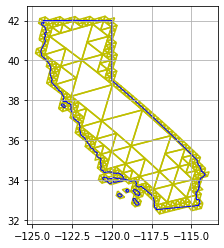

In [14]:
fig, ax = plt.subplots()
ax.grid(True)

state = us[us.NAME=='California']
state.plot(ax=ax, trixels=True, boundary=True, color='y', zorder=0)
state.plot(ax=ax, trixels=False, facecolor="none", edgecolor='blue', zorder=1)

## Africa

In [ ]:
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
world.sort_values(by='name', inplace=True)
africa = world[world.continent=='Africa']

In [ ]:
stare = starepandas.stare_from_gdf(africa, level=8, force_ccw=True)
africa = starepandas.STAREDataFrame(africa, stare=stare)
trixels = africa.trixels()
africa.set_trixels(trixels, inplace=True)

In [ ]:
fig, ax = plt.subplots(figsize=(13,5), dpi=300)
ax.grid(True)

africa.plot(ax=ax, trixels=True, boundary=True, 
            column='name', linewidth=0.2)

#fig.savefig('africa.png')

## Holes in RSA

In [ ]:
rsa = africa[africa.name=='South Africa']

In [ ]:
fig, ax = plt.subplots()
ax.grid(True)

rsa.plot(ax=ax, trixels=True, boundary=True, color='y', lw=1, zorder=0)
rsa.plot(ax=ax, trixels=False, facecolor="none", edgecolor='blue', lw=1, zorder=1)

In [ ]:
p = rsa.iloc[0].geometry
interior = starepandas.from_boundary(p.interiors[0], level=12, force_ccw=False)

## Puerto Rico (GPKG)

In [ ]:
file = 'data/caribbean.gpkg'
gdf = geopandas.read_file(file)

# Sanitation
gdf.rename(columns={'NAME_0': "name"}, inplace=True)
gdf.sort_values(by='name', inplace=True)
gdf.set_index('ISO', inplace=True)
gdf = gdf[['name', 'geometry']]

# Adding simple geom
gdf['geom_simple'] = gdf.simplify(0.001)
gdf.set_geometry('geom_simple', inplace=True)

In [ ]:
stare = starepandas.stare_from_gdf(gdf, level=11, force_ccw=True)
sdf = starepandas.STAREDataFrame(gdf, stare=stare)

In [ ]:
trixels = sdf.trixels()
sdf.set_trixels(trixels, inplace=True)

In [ ]:
fig, ax = plt.subplots(figsize=(13,5), dpi=300)
ax.grid(True)

pr = sdf[sdf['name']=='Puerto Rico']
pr.plot(ax=ax, trixels=True, color='y', lw=1, zorder=0)
pr.plot(ax=ax, trixels=False, facecolor="none", edgecolor='blue', lw=1, zorder=1)